In [1]:
!pip install pandas
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install numpy

     |████████████████████████████████| 9.9 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 69.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 72.3 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 63.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 72.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 4.4 MB/s eta 0:00:01


In [2]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# df = pd.read_excel('IDD_To_Train.xlsx')
df = pd.read_csv('IDDROI_AggregatedData-R6.csv')

In [4]:
df

,Date,Include?,Country,City,Utilization_Tests,Adobe_Engaged Visits,Adobe_Unique Visitors,SearchTrend_Value,Email_Opens,Sales_Calls,Utilization_InstCount,Utilization_MemberCount
0,1/1/2019,1,Austria,Wien,63031,21,63,2020102,0,9,15,6
1,1/1/2019,1,Austria,ST. PÖLTEN,687,0,0,22018,0,0,1,1
2,1/1/2019,1,Austria,SALZBURG,7928,3,8,254087,0,1,2,1
3,1/1/2019,1,Austria,Linz,10709,4,10,343216,0,1,4,2
4,1/1/2019,1,Austria,Stolzalpe,12623,4,13,404559,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12255,4/1/2021,0,Netherlands,ALKMAAR,3767,43,55,3426772,0,2,2,1
12256,4/1/2021,0,Netherlands,AMSTERDAM,918,10,13,835088,0,0,1,1
12257,4/1/2021,0,Netherlands,GOES,1638,19,24,1490059,0,1,1,1
12258,4/1/2021,0,Netherlands,HOORN,1353,15,20,1230800,0,1,1,1


In [5]:
#Model some type of nonlinearity
df['drdr'] = df['Utilization_InstCount']*df['Utilization_InstCount']
df['log2dr'] = np.log2(df['Utilization_InstCount'])

In [6]:
#Scale SearchTrend_Value
df['SearchTrend_Modified'] = df['SearchTrend_Value']/1000

In [7]:
#Fix any place where the log2 is -infinity (log of 0)
df.loc[df['log2dr']==-np.inf,'log2dr'] = 0

In [9]:
# train = df[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Revenue','Calls','Tenure']]
# X = train[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Calls','Tenure']]
# X_ols = train[['AffectedPop','UV','NumReps','Staffed']]
train = df[['Date','Country','City',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_InstCount','drdr','log2dr','Utilization_Tests']]
X = train[['Date','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_InstCount','drdr','log2dr']]
X_ols = train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_InstCount','drdr','log2dr']]
y = train['Utilization_Tests']

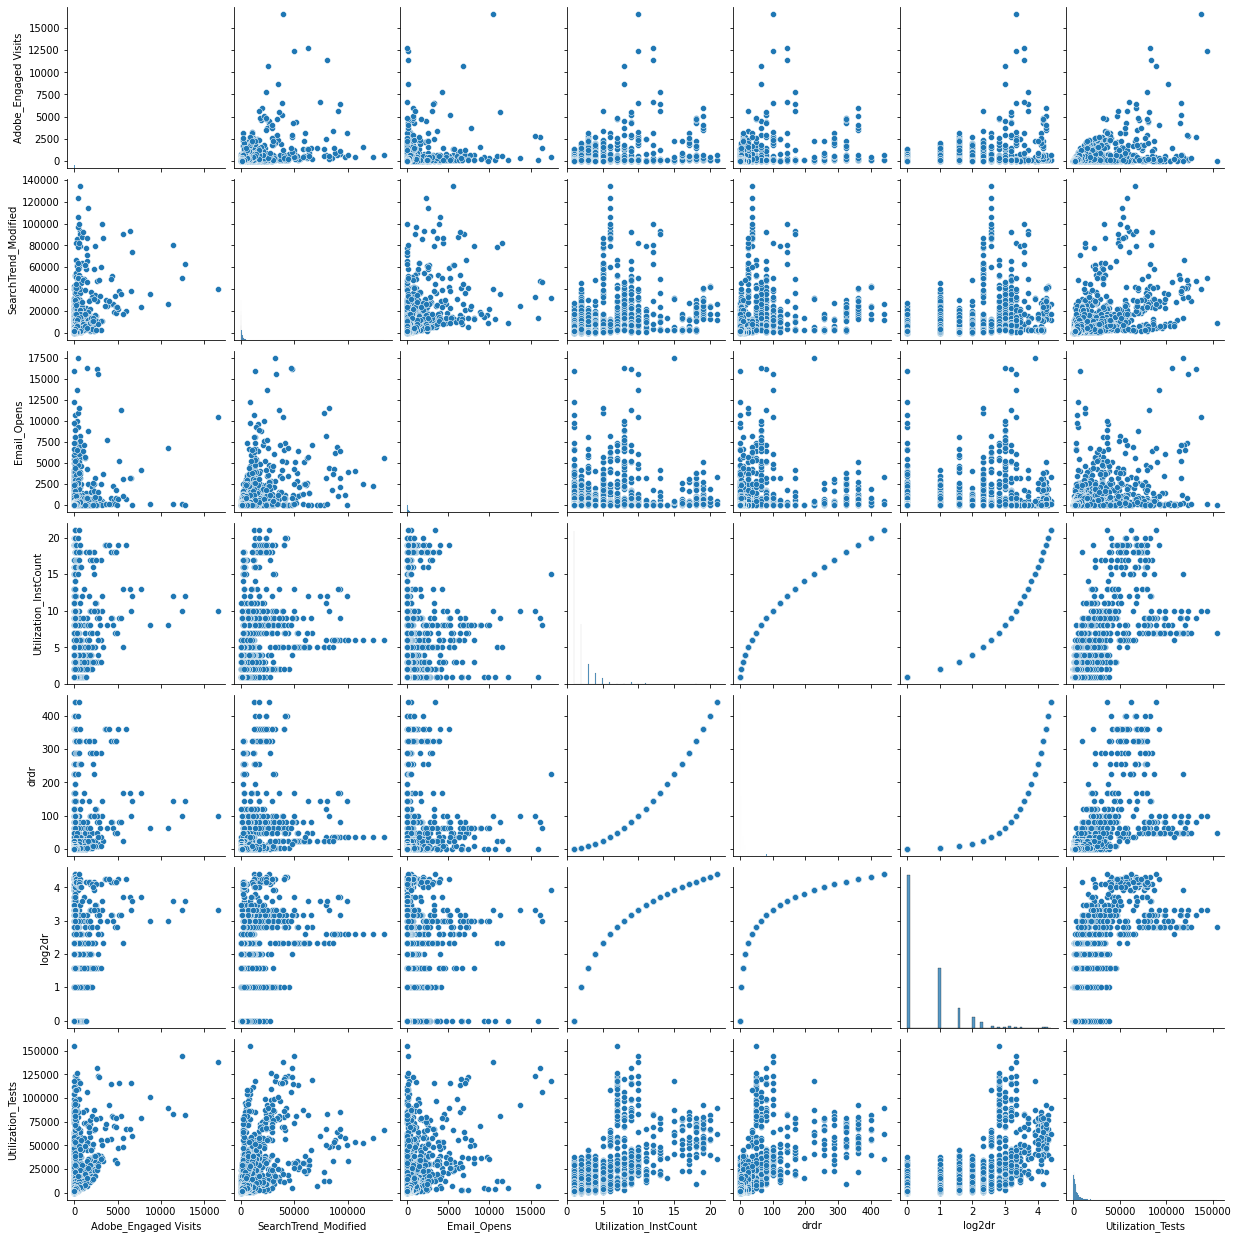

In [10]:
#Look at interactions between the variables. Not very many great relationships except definitely some interactions between # of Drs and Revenue
sns.pairplot(train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Utilization_InstCount','drdr','log2dr','Utilization_Tests']])
plt.show()

In [11]:
!pip install sklearn

     |████████████████████████████████| 22.3 MB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 72.7 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=66bfc2b403b612d89b65889f88ebd2e808668af740b60f021cccb2c63c747122
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [12]:
#Split the data into train/test datasets and get ready to build a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor()
X = pd.get_dummies(X)

x_train, x_test, y_train, y_test = train_test_split(X,y)

In [14]:
#Train an OLS regression on the original dataset (NOT INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_InstCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(X[train_test_cols])
x_train_orig = sm.tools.add_constant(X[train_test_cols[:-2]])
mod = sm.GLS(y, x_train_orig)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(X[train_test_cols[:-2]])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.719
Model:                            GLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     6271.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        01:22:07   Log-Likelihood:            -1.2345e+05
No. Observations:               12260   AIC:                         2.469e+05
Df Residuals:                   12254   BIC:                         2.470e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1919.99

In [17]:
#Train an OLS regression on the modified dataset (INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_InstCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(X[train_test_cols])
x_train_orig = sm.tools.add_constant(X[train_test_cols[:-2]])
mod = sm.GLS(y, x_train_all)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(X[train_test_cols])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.725
Model:                            GLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     4605.
Date:                Fri, 14 May 2021   Prob (F-statistic):               0.00
Time:                        01:24:33   Log-Likelihood:            -1.2332e+05
No. Observations:               12260   AIC:                         2.467e+05
Df Residuals:                   12252   BIC:                         2.467e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4953.81

In [23]:
#Fit the random forest and predict the values for the test dataset

rf.fit(X,y)
y_predict_rf = rf.predict(X)

In [19]:
#Which variables are most important for the random forest? Number of doctors is the strongest predictor
importances = pd.DataFrame(list(zip(*[x_train.columns,rf.feature_importances_])),columns=['variable','importance'])
importances.sort_values('importance',ascending=False)

,variable,importance
5,drdr,0.234262
6,log2dr,0.204366
4,Utilization_InstCount,0.192056
1,SearchTrend_Modified,0.117598
45,Country_Norway,0.059117
3,Sales_Calls,0.053033
41,Country_France,0.049959
36,Country_Belgium,0.009813
2,Email_Opens,0.009770
0,Adobe_Engaged Visits,0.009718


In [20]:
#Import functions to calculate metrics from sklearn to make it easier to ensure I'm calculating it correctly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
mse_rf = mean_squared_error(y, y_predict_rf)
mae_rf = mean_absolute_error(y, y_predict_rf)
r2_rf = r2_score(y, y_predict_rf)
mse_ols = mean_squared_error(y, y_predict_ols)
mae_ols = mean_absolute_error(y, y_predict_ols)
r2_ols = r2_score(y, y_predict_ols)

print(f'OLS\nMSE: {mse_ols:0,.0f}\t\tMAE: {mae_ols:0,.1f}\t\tR-Squared: {r2_ols:0.3f}')
print()
print(f'Random Forest\nMSE: {mse_rf:0,.0f}\t\tMAE: {mae_rf:0,.1f}\t\tR-Squared: {r2_rf:0.3f}')

OLS
MSE: 31,968,020		MAE: 2,326.8		R-Squared: 0.725

Random Forest
MSE: 787,129		MAE: 249.5		R-Squared: 0.993


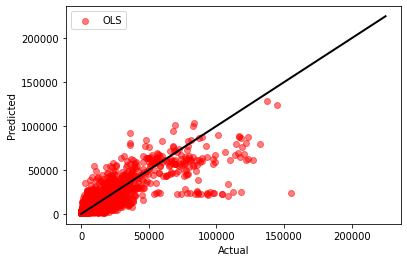

In [25]:
#How closely to the y=x line do the OLS predictions run?
plt.scatter(y, y_predict_ols, alpha=0.5, c='r', label='OLS')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

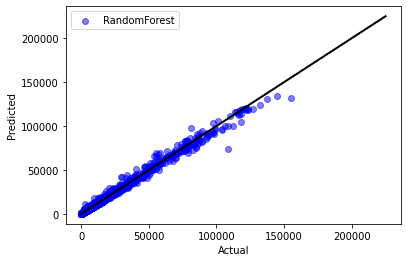

In [26]:
#How closely to the y=x line do the random forest predictions run?
plt.scatter(y, y_predict_rf, alpha=0.5, c='b', label='RandomForest')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()